# 📊 YouTube Channel Analysis — Notebook

This notebook uses the **YouTube Data API v3** to extract, analyze, and visualize channel and video statistics.

**What you'll learn**
- Authenticate with an API key (no OAuth)
- Fetch channel- and video-level stats
- Clean and analyze data with `pandas`
- Visualize results with `matplotlib`/`seaborn`
- Handle batching (50 IDs) and retries for network hiccups

> **Note:** Keep your API key **out of the notebook**. Use environment variables or a `.env` file.


In [1]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns

In [2]:
# Import libraries
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API key
api_key = os.getenv("API_KEY")

# Verify
if api_key:
    print("✅ API Key loaded successfully!")
else:
    print("❌ API Key not found. Check your .env file.")

# Example: use API_KEY in a request
# import requests
# response = requests.get("https://api.example.com/data", headers={"Authorization": f"Bearer {API_KEY}"})
# print(response.json())


✅ API Key loaded successfully!


In [3]:
channel_ids = ['UC7cs8q-gJRlGwj4A8OmCmXg', #Alex The Analyst
               'UC8_RSKwbU1OmZWNEoLV1tQg', #Data with Bara
               'UCLLw7jmFsvfIVaUFsLs8mlQ', #Luke Barousse
               'UCiT9RITQ9PW6BhXK0y2jaeg', #Ken Jee
               'UC2UXDak6o7rBm23k3Vv5dww' #Tina Huang
              ]

# Get credentials and create an API client
#youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)
youtube = build('youtube', 'v3', developerKey=api_key)

## Part 1 : Scrape Channel Statistics from YouTube

## Function to get channel statistics

In [4]:
def get_channel_stats(youtube, channel_ids):

    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids))
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(ChannelName = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    TotalVideos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads']
                   )
        
        all_data.append(data)

    return all_data

In [5]:
channel_statistics = get_channel_stats(youtube, channel_ids)

In [6]:
channel_data = pd.DataFrame(channel_statistics)

In [7]:
channel_data

,ChannelName,Subscribers,Views,TotalVideos,playlist_id
0,Alex The Analyst,1130000,53521850,387,UU7cs8q-gJRlGwj4A8OmCmXg
1,Ken Jee,274000,9502050,288,UUiT9RITQ9PW6BhXK0y2jaeg
2,Luke Barousse,551000,27556220,165,UULLw7jmFsvfIVaUFsLs8mlQ
3,Data with Baraa,155000,7251080,321,UU8_RSKwbU1OmZWNEoLV1tQg
4,Tina Huang,982000,42805729,271,UU2UXDak6o7rBm23k3Vv5dww


In [8]:
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['TotalVideos'] = pd.to_numeric(channel_data['TotalVideos'])

channel_data.dtypes

ChannelName    object
Subscribers     int64
Views           int64
TotalVideos     int64
playlist_id    object
dtype: object

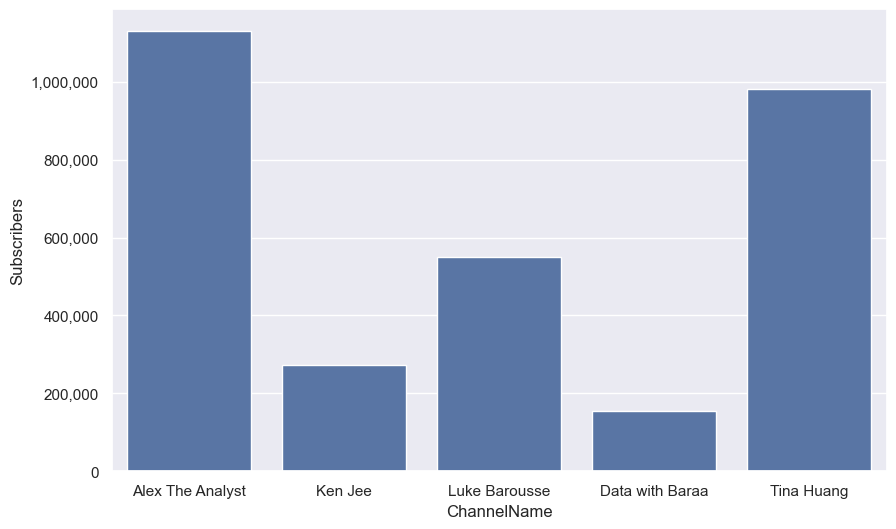

In [9]:
import matplotlib.ticker as ticker

sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x='ChannelName', y='Subscribers', data=channel_data)

# Format Y-axis with commas instead of scientific notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))


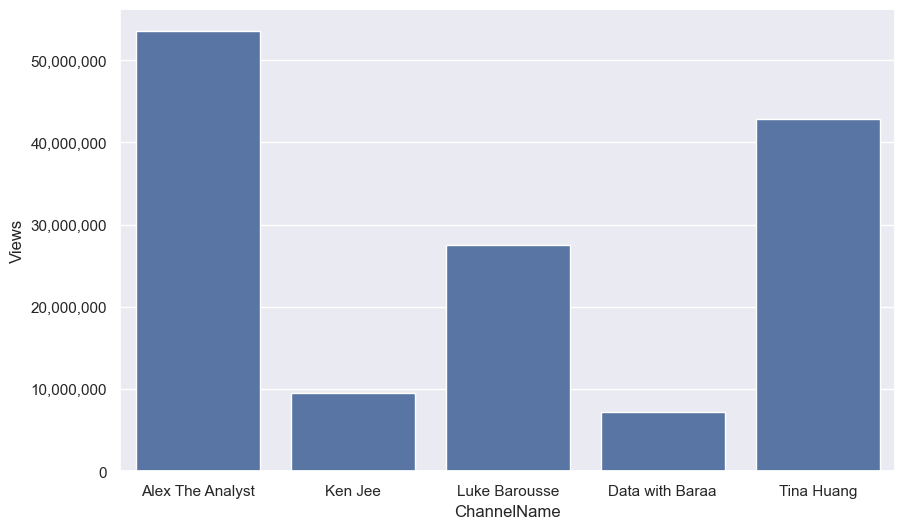

In [10]:
ax = sns.barplot(x='ChannelName', y='Views', data=channel_data)

# Format Y-axis with commas instead of scientific notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

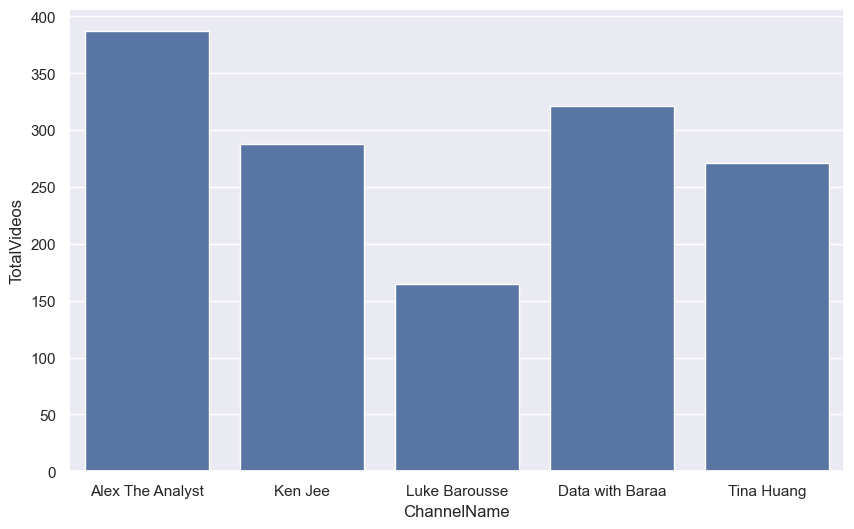

In [11]:
ax = sns.barplot(x='ChannelName', y='TotalVideos', data=channel_data)

# Format Y-axis with commas instead of scientific notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

## Part 2: Scrape, Analyze & Visualize Video Details

In [12]:
channel_data

,ChannelName,Subscribers,Views,TotalVideos,playlist_id
0,Alex The Analyst,1130000,53521850,387,UU7cs8q-gJRlGwj4A8OmCmXg
1,Ken Jee,274000,9502050,288,UUiT9RITQ9PW6BhXK0y2jaeg
2,Luke Barousse,551000,27556220,165,UULLw7jmFsvfIVaUFsLs8mlQ
3,Data with Baraa,155000,7251080,321,UU8_RSKwbU1OmZWNEoLV1tQg
4,Tina Huang,982000,42805729,271,UU2UXDak6o7rBm23k3Vv5dww


In [13]:
playlist_id = channel_data.loc[channel_data['ChannelName']=='Alex The Analyst','playlist_id'].iloc[0]

In [14]:
## Function to get VideoIds
def get_video_ids(youtube, playlist_id):

    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults=50)

    response = request.execute()

    video_ids = []
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId=playlist_id,
                maxResults=50,
            pageToken = next_page_token)
        
            response = request.execute()
            
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')
    
    return video_ids

In [15]:
video_ids = get_video_ids(youtube, playlist_id)
video_ids

['yhlqKsYpzgE',
 'kk5zEOQzTmQ',
 'TP2OJuZhbIQ',
 'Mi8st3hyMH8',
 'vAKs1-EEJ38',
 '-Z2KjOUcvTA',
 'v5jasYkmwZI',
 'kqhJff8ruKw',
 'QR8kxf925IQ',
 'klKWFqsqFeI',
 'XIWe4vCtHcY',
 'PqCp1f0RIaU',
 '0B-lz9VQkYs',
 '_YG8b1g-QJA',
 'UT_hTGge_wc',
 'A42T_b0gwF4',
 '8NfozskpBtY',
 'lpK71OwmG0s',
 'QC1Jased-PA',
 'O5nQKzBb0oc',
 '73S2SJSTgQU',
 'TsnGd6p9oTk',
 'DsI1vG-kXR8',
 '4lhPHhPkVLM',
 'dkU5n0G7FRQ',
 'kagUDLvrcZ8',
 'P5uJYPjUtlc',
 'dStNNjOKML4',
 'OQM9x6E3ojo',
 'z39SB95JbDo',
 'W5CQb7klLCs',
 'xb5-UX-jYw0',
 'V3ouFOBQP0k',
 'oi9W142ELN0',
 '5n52mlp9Ym0',
 'hgp91KvbJV4',
 '1ql4kNv0_qY',
 'r5512UY3MTc',
 'XuOcmjIbFGg',
 'Ka2mDrKEAhg',
 'k8nBWL6K884',
 'WpX2F2BS3Qc',
 'cd_jj0IRmaA',
 'OcG0B4ny1cE',
 'hXpt8zj_ajc',
 'ItZlTixh6Bs',
 'PEWMgtu-1e4',
 'hCmEfxy-BXg',
 'TtCBz1lutsY',
 'Ihmq-qeA5Pc',
 'wQQR60KtnFY',
 'oHte3qFa-oY',
 'P7p2OZj9ewU',
 'I0vQ_VLZTWg',
 'tnz72ywhCoo',
 'j8FSP8XuFyk',
 'zXnQNytHCPM',
 'osA1QpBcxRs',
 'Mdq1WWSdUtw',
 'CZt2BUpgjgw',
 't1fQBD4B7xk',
 'OT1RErkfLNQ',
 'rxyLC2

## Function to get video details

In [16]:
def get_video_details(youtube, video_ids):

    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet,statistics',
            id=','.join(video_ids[i:i+50]))
        response = request.execute()

        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Favorite = video['statistics']['favoriteCount'],
                               Comments = video['statistics']['commentCount'],
                              )
            all_video_stats.append(video_stats)
            
    return all_video_stats

In [17]:
video_details = get_video_details(youtube, video_ids)

In [18]:
video_data = pd.DataFrame(video_details)
video_data

,Title,Published_date,Views,Likes,Favorite,Comments
0,Alex The Analyst Q/A Livestream | Come Ask Me ...,2025-08-21T14:09:29Z,2367,115,0,11
1,Data Visualization and Presentation in R | R f...,2025-08-19T12:01:22Z,2318,68,0,10
2,Things I Learned as a Data Analyst p1,2025-08-15T11:46:04Z,6361,221,0,12
3,Alex The Analyst Q/A Livestream | Come Ask Me ...,2025-08-14T14:18:24Z,2849,111,0,8
4,How to Remove Duplicates in an R Dataframe | R...,2025-08-12T12:01:49Z,1799,60,0,2
...,...,...,...,...,...,...
382,Data Analyst Resume | Reviewing My Resume! | F...,2020-01-30T14:07:55Z,82673,1781,0,63
383,Working at a Big Company Vs Small Company | To...,2020-01-25T16:38:39Z,16071,432,0,23
384,Data Analyst Salary | 100k with No Experience,2020-01-23T03:16:09Z,66395,2247,0,220
385,Truth About Big Companies | Told by a Fortune ...,2020-01-21T03:52:15Z,9862,356,0,20


In [19]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Favorite'] = pd.to_numeric(video_data['Favorite'])
video_data['Comments'] = pd.to_numeric(video_data['Comments'])

video_data

,Title,Published_date,Views,Likes,Favorite,Comments
0,Alex The Analyst Q/A Livestream | Come Ask Me ...,2025-08-21,2367,115,0,11
1,Data Visualization and Presentation in R | R f...,2025-08-19,2318,68,0,10
2,Things I Learned as a Data Analyst p1,2025-08-15,6361,221,0,12
3,Alex The Analyst Q/A Livestream | Come Ask Me ...,2025-08-14,2849,111,0,8
4,How to Remove Duplicates in an R Dataframe | R...,2025-08-12,1799,60,0,2
...,...,...,...,...,...,...
382,Data Analyst Resume | Reviewing My Resume! | F...,2020-01-30,82673,1781,0,63
383,Working at a Big Company Vs Small Company | To...,2020-01-25,16071,432,0,23
384,Data Analyst Salary | 100k with No Experience,2020-01-23,66395,2247,0,220
385,Truth About Big Companies | Told by a Fortune ...,2020-01-21,9862,356,0,20


In [20]:
top10_videos = video_data.sort_values(by='Views',ascending=False).head(10)
top10_videos

,Title,Published_date,Views,Likes,Favorite,Comments
292,Data Analyst Portfolio Project | SQL Data Expl...,2021-05-04,2215995,37583,0,4399
195,FREE Data Analyst Bootcamp!!,2023-02-07,2179424,50486,0,1969
375,SQL Basics Tutorial For Beginners | Installing...,2020-03-01,1481785,18771,0,2057
196,How to Become a Data Analyst in 2023 (Complete...,2023-01-31,1406060,45484,0,1423
128,Installing MySQL and Creating Databases | MySQ...,2023-10-31,1169640,14854,0,1609
252,Full Project in Excel | Excel Tutorials for Be...,2022-03-22,1068745,21928,0,1231
352,What Does a Data Analyst Actually Do?,2020-07-29,1068048,20472,0,515
266,Pivot Tables in Excel | Excel Tutorials for Be...,2021-12-14,1046225,20507,0,474
246,Database vs Data Warehouse vs Data Lake | What...,2022-04-26,963350,24679,0,344
350,Top 5 Reasons Not to Become a Data Analyst,2020-08-12,927804,19742,0,1047


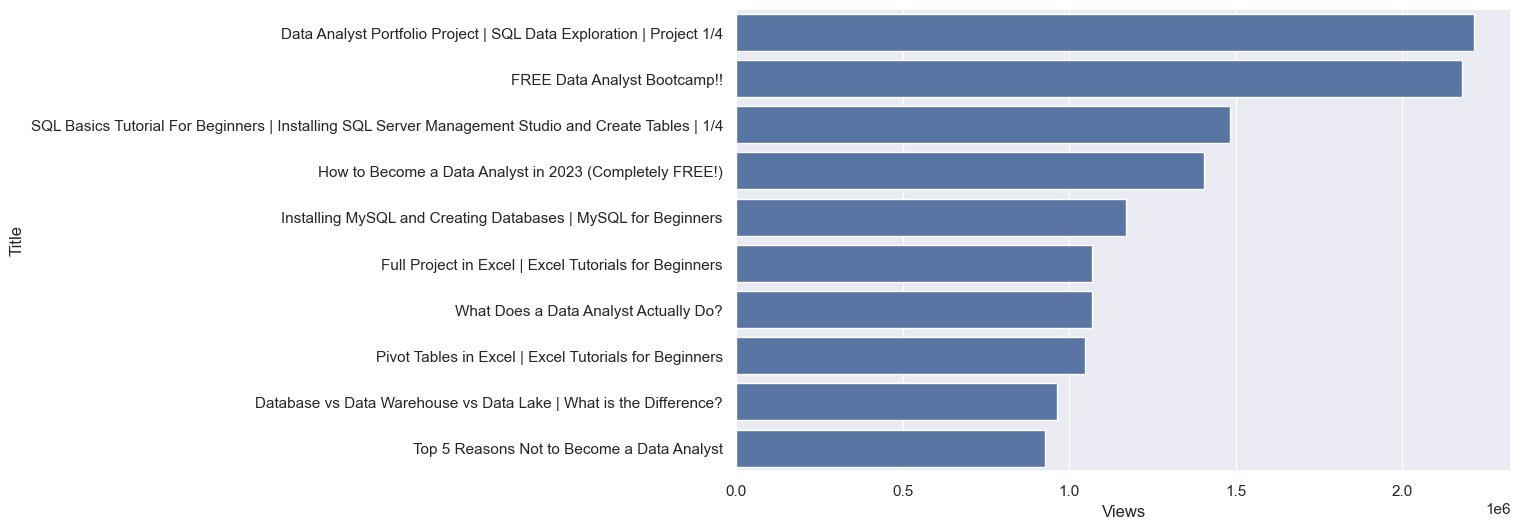

In [21]:
ax1 = sns.barplot(x='Views', y='Title', data=top10_videos)

In [22]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')
video_data

,Title,Published_date,Views,Likes,Favorite,Comments,Month
0,Alex The Analyst Q/A Livestream | Come Ask Me ...,2025-08-21,2367,115,0,11,Aug
1,Data Visualization and Presentation in R | R f...,2025-08-19,2318,68,0,10,Aug
2,Things I Learned as a Data Analyst p1,2025-08-15,6361,221,0,12,Aug
3,Alex The Analyst Q/A Livestream | Come Ask Me ...,2025-08-14,2849,111,0,8,Aug
4,How to Remove Duplicates in an R Dataframe | R...,2025-08-12,1799,60,0,2,Aug
...,...,...,...,...,...,...,...
382,Data Analyst Resume | Reviewing My Resume! | F...,2020-01-30,82673,1781,0,63,Jan
383,Working at a Big Company Vs Small Company | To...,2020-01-25,16071,432,0,23,Jan
384,Data Analyst Salary | 100k with No Experience,2020-01-23,66395,2247,0,220,Jan
385,Truth About Big Companies | Told by a Fortune ...,2020-01-21,9862,356,0,20,Jan


In [23]:
videos_per_month = video_data.groupby('Month', as_index=False).size()
videos_per_month

,Month,size
0,Apr,30
1,Aug,41
2,Dec,29
3,Feb,30
4,Jan,38
5,Jul,36
6,Jun,26
7,Mar,35
8,May,31
9,Nov,27


In [24]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [25]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)

In [26]:
videos_per_month = videos_per_month.sort_index()

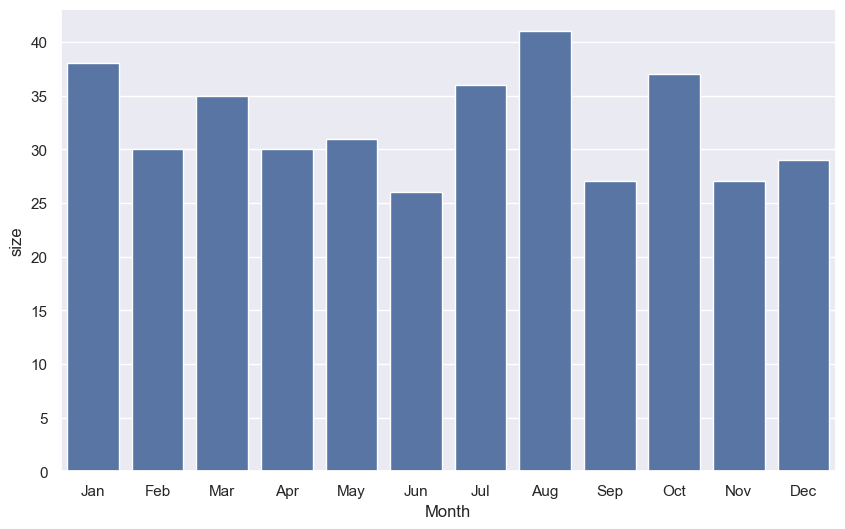

In [27]:
ax2 = sns.barplot(x='Month', y='size', data=videos_per_month)

In [28]:
video_data.to_csv('Video_Details_Alex.csv')